<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/jax_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Training on MNIST

In [ ]:
import jax.numpy as jnp
import jax
import numpy as np
from jax.scipy.special import logsumexp
from jax import jit, vmap, pmap, grad

In [ ]:
MNIST_IMG_SIZE = (28, 28)

### Initializing Weights

In [ ]:
seed = 0

def init_weights(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)


    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        # For every layer i, (of weight dims layer_widths[i]):
        weight_key, bias_key = jax.random.split(key)

        params.append([
                scale*jax.random.normal(weight_key, shape=(out_width, in_width)),  # Weights (in, out)
                scale*jax.random.normal(bias_key, shape=(out_width,)) # Biases (out)
            ]
        )

    return params

key = jax.random.PRNGKey(seed)
MLP_params = init_weights([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, MLP_params))


[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


### Inferencing

$$\mathrm{logsumexp}(a) = \mathrm{log} \sum_j b \cdot \mathrm{exp}(a_{ij})$$

In [ ]:
def predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # Mimicking softmax
    # log(exp(o1)) - log(sum(exp(o1),exp(o2), ...)))
    return logits - logsumexp(logits)

In [ ]:
dummy_img = np.random.randn(np.prod(MNIST_IMG_SIZE))
print(dummy_img.shape)

prediction = predict(MLP_params, dummy_img)
print(prediction.shape)

batched_predict = vmap(predict, in_axes=(None, 0))

batched_dummy_imgs = np.random.randn(16, np.prod(MNIST_IMG_SIZE))
print(batched_dummy_imgs.shape)

batched_predictions = batched_predict(MLP_params, batched_dummy_imgs)
print(batched_predictions.shape)


(784,)
(10,)
(16, 784)
(16, 10)


### MNIST Dataloader

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [ ]:
import os

if not os.path.exists("./data"):
    os.mkdir("./data")
if not os.path.exists("./data/train"):
    os.mkdir("./data/train")
if not os.path.exists("./data/test"):
    os.mkdir("./data/test")

In [ ]:
def convert_to_numpy(x):
    return np.ravel(np.array(x, dtype=np.float32))

train_dataset = MNIST(root='./data/train', train=True, download=True, transform=convert_to_numpy)
test_dataset = MNIST(root='./data/test', train=False, download=True, transform=convert_to_numpy)

print(type(train_dataset))
image = train_dataset[0][0]
label = train_dataset[0][1]
print(type(image), type(label))
print(image.shape)

<class 'torchvision.datasets.mnist.MNIST'>
<class 'numpy.ndarray'> <class 'int'>
(784,)


In [ ]:
def collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels


BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# batch_data = next(iter(train_loader))
# imgs = batch_data[0]
# lbls = batch_data[1]
# print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

### Training Loop

In [ ]:
import tqdm

NUM_EPOCHS = 10
LEARNING_RATE = 0.01


def loss_fn(params, images, gt_labels, lr=0.01):
    preds = batched_predict(params, images)  # (b,10)
    return -jnp.mean(preds * gt_labels)

@jit
def update(params, images, gt_labels, lr=0.01):
    loss, grads = jax.value_and_grad(loss_fn)(params, images, gt_labels)
    return loss, jax.tree.map(lambda p, g: p - lr * g, params, grads)

def compute_accuracy(preds, gt_labels):
    pred_class = jnp.argmax(preds, axis=-1)
    true_class = jnp.argmax(gt_labels, axis=-1)
    return jnp.mean(pred_class == true_class)

MLP_params = init_weights([np.prod(MNIST_IMG_SIZE), 512, 256, len(MNIST.classes)], key)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = 0

    for imgs, gt_labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=True):
        gt_labels = jax.nn.one_hot(gt_labels, num_classes=len(MNIST.classes))
        preds = batched_predict(MLP_params, imgs)
        loss, MLP_params = update(MLP_params, imgs, gt_labels, LEARNING_RATE)

        accuracy = compute_accuracy(preds, gt_labels)

        epoch_loss += loss
        epoch_accuracy += accuracy
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    avg_accuracy = epoch_accuracy / num_batches
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_accuracy*100:.2f}%")

Epoch 1/10: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]


Epoch 1: Loss = 0.0551, Accuracy = 85.50%


Epoch 2/10: 100%|██████████| 469/469 [00:09<00:00, 48.90it/s]


Epoch 2: Loss = 0.0266, Accuracy = 92.37%


Epoch 3/10: 100%|██████████| 469/469 [00:09<00:00, 51.94it/s]


Epoch 3: Loss = 0.0213, Accuracy = 93.98%


Epoch 4/10: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]


Epoch 4: Loss = 0.0180, Accuracy = 94.94%


Epoch 5/10: 100%|██████████| 469/469 [00:09<00:00, 48.16it/s]


Epoch 5: Loss = 0.0156, Accuracy = 95.62%


Epoch 6/10: 100%|██████████| 469/469 [00:09<00:00, 48.21it/s]


Epoch 6: Loss = 0.0138, Accuracy = 96.11%


Epoch 7/10: 100%|██████████| 469/469 [00:08<00:00, 52.28it/s]


Epoch 7: Loss = 0.0123, Accuracy = 96.51%


Epoch 8/10: 100%|██████████| 469/469 [00:09<00:00, 49.96it/s]


Epoch 8: Loss = 0.0111, Accuracy = 96.86%


Epoch 9/10: 100%|██████████| 469/469 [00:09<00:00, 49.61it/s]


Epoch 9: Loss = 0.0101, Accuracy = 97.10%


Epoch 10/10: 100%|██████████| 469/469 [00:09<00:00, 49.10it/s]

Epoch 10: Loss = 0.0092, Accuracy = 97.43%


(28, 28)


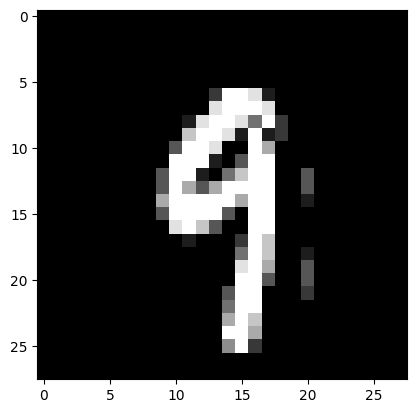

label 9, pred 9


In [ ]:
imgs, labels = next(iter(test_loader))
img = imgs[0].reshape(MNIST_IMG_SIZE)
gt_label = labels[0]
print(img.shape)

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()
print('label', gt_label, end=', ')

pred = predict(MLP_params, np.ravel(img))
print('pred', np.argmax(pred))

# Plotting

In [ ]:
from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))

In [ ]:
images, labels = next(iter(test_loader))

batched_activations = batched_fetch_activations(MLP_params, images)
# Just before being projected into logits
print(batched_activations.shape) # Rep. Learning -> Second-to-last layer activations

(128, 256)


In [ ]:
label_to_color_map = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange",
    5: "cyan",
    6: "magenta",
    7: "brown",
    8: "pink",
    9: "gray"
}

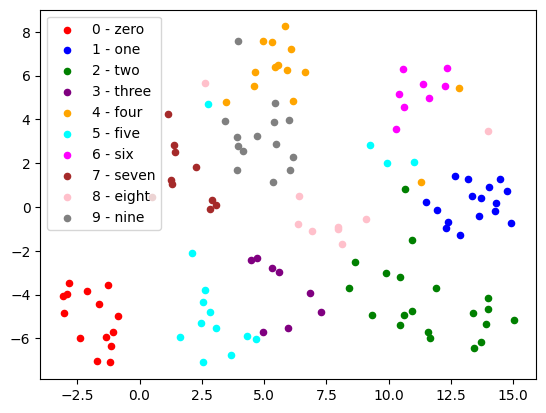

In [ ]:
tsne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batched_activations)

for class_id in range(len(MNIST.classes)):
    plt.scatter(tsne_embeddings[labels == class_id, 0], tsne_embeddings[labels == class_id, 1], s=20, color=label_to_color_map[class_id], label=MNIST.classes[class_id])

plt.legend()
plt.show()